"4"
"4-8"
"*"
"4-8, 10"
"4-8, 10-12"
"4-*"

In [49]:
import mne_bids
from pathlib import Path
datafolder = "./derivatives"
process = "gradient_removal"
subject = None
session = "01"
task = "rest"
run = "01"
description = None
datatype = "eeg"
suffix = "eeg"

reading_root = Path(datafolder, process)
bids_path = mne_bids.BIDSPath(subject='*', 
                              session=session, 
                              task=task, 
                              run=run, 
                              description=description,
                              datatype=datatype, 
                              root=reading_root,
                              suffix = None,
                              extension=".fif")
mne_bids.print_dir_tree(bids_path.fpath.parent, max_depth=3)

FileNotFoundError: Folder does not exist: "/Users/samuel/codes/eeg_fmri/derivatives/gradient_removal/sub-*/ses-01/eeg"

In [15]:
import numpy as np
from scipy.signal import correlate
import mne
from mne.preprocessing import (ICA, create_ecg_epochs, create_eog_epochs, corrmap)
import matplotlib.pyplot as plt
from GradientRemover import GradientRemover
raw = mne.io.read_raw_brainvision('/Users/samuel/codes/eeg_fmri/derivatives/gradient_removal/sub-06/ses-01/eeg/sub-06_ses-01_task-rest_run-01_eeg.vhdr',
                                  preload=True)
channels_mapping = {
    'ECG': 'ecg',
    'EOGU': 'eog',
    'EOGL': 'eog',
}
raw.set_channel_types(channels_mapping)
raw.set_montage('standard_1005', on_missing='ignore')
raw.filter(1, None)
ev = mne.events_from_annotations(raw, event_id = {'Stimulus/R128' : 0})
g_remover = GradientRemover(raw.get_data(),ev[0], window=(2,2))
raw_corrected = g_remover.correct()
raw = mne.io.RawArray(raw_corrected, raw.info)
raw.filter(1,40).resample(250)
#raw_corrected.notch_filter(np.arange(17, 50, 17))
#raw.plot_psd()


Extracting parameters from /Users/samuel/codes/eeg_fmri/derivatives/gradient_removal/sub-06/ses-01/eeg/sub-06_ses-01_task-rest_run-01_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 3134099  =      0.000 ...   626.820 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 16501 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Used Annotations descriptions: ['Stimulus/R128']


/Users/samuel/anaconda3/envs/mne/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/samuel/anaconda3/envs/mne/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Creating RawArray with float64 data, n_channels=64, n_times=3134100
    Range : 0 ... 3134099 =      0.000 ...   626.820 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 16501 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,64 points
Good channels,"61 EEG, 1 ECG, 2 EOG"
Bad channels,None
EOG channels,"EOGL, EOGU"
ECG channels,ECG
Sampling frequency,250.00 Hz
Highpass,1.00 Hz
Lowpass,40.00 Hz


In [1]:
import mne_bids
from pathlib import Path

datafolder = "./derivatives"
process = "gradient_removal"
subject = "04"
session = "01"
task = "rest"
run = "01"
description = None
datatype = "eeg"
suffix = "eeg"

reading_root = Path(datafolder, process)
bids_path = mne_bids.BIDSPath(subject=subject, 
                              session=session, 
                              task=task, 
                              run=run, 
                              description=description,
                              datatype=datatype, 
                              root=reading_root,
                              suffix = "eeg",
                              extension=".edf")
bids_path.mkdir()

BIDSPath(
root: derivatives/gradient_removal
datatype: eeg
basename: sub-04_ses-01_task-rest_run-01_eeg.set)

# Opening and exploring visualy the data
I am going to work on a `mne.io.Raw` object. This object contains the continuous data from the EEG recording. It also contains all type of information about the recording, such as the sampling frequency, the channel names, etc. Then I am going to filter then resample the data. Finally I am going to plot the data to see how it looks like. On the plot I will add manually segments that I know are artefactuals and that could make the future ICA computation crazy. After that I will save the data to save my annotations. The saving folder will become the working folder in the rest of the notebook.

In [18]:
import mne
import mne_bids
import os
from pathlib import Path
import numpy as np

datafolder = "./derivatives"
process = "gradient_removal"
subject = "01"
session = "01"
task = "rest"
run = "01"
description = None
datatype = "eeg"
suffix = "eeg"

reading_root = Path(datafolder, process)
bids_path = mne_bids.BIDSPath(subject=subject, 
                              session=session, 
                              task=task, 
                              run=run, 
                              description=description,
                              datatype=datatype, 
                              root=reading_root,
                              suffix = "eeg",
                              extension=".edf")

raw = mne.io.read_raw_edf(bids_path.fpath, preload=True)
#raw = mne.io.read_raw_eeglab(bids_path.fpath)
raw.filter(1,50).resample(250)
raw.notch_filter(np.arange(18, 56, 18), filter_length='auto', phase='zero')
raw.plot(block=True)

saving_root = Path(datafolder, "ballistocardiography_removal")
bids_path.update(root=saving_root,
                 description="badsegmentannotated",
                 extension = ".fif")
bids_path.mkdir()
saving_filename = str(bids_path.fpath)
raw.save(saving_filename, overwrite=True)


Extracting EDF parameters from /Users/samuel/codes/eeg_fmri/derivatives/gradient_removal/sub-01/ses-01/eeg/sub-01_ses-01_task-rest_run-01_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 155749  =      0.000 ...   622.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 825 samples (3.300 s)

Sampling frequency of the instance is already 250.0, returning unmodified.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Using pyopengl with version 3.1.6
Channels marked as bad:
none
Overwriting existing file.
Writing /Users/samuel/codes/eeg_fmri/derivatives/ballistocardiography_removal/sub-01/ses-01/eeg/sub-01_ses-01_task-rest_run-01_desc-badsegmentannotated_eeg.fif
Closing /Users/samuel/codes/eeg_fmri/derivatives/ballistocardiography_removal/sub-01/ses-01/eeg/sub-01_ses-01_task-rest_run-01_desc-badsegmentannotated_eeg.fif
[done]


## If marked data already exists
No need to go through visual inspection again and again.

In [3]:

import mne
import mne_bids
import os
from pathlib import Path

DATAFOLDER= "derivatives"
process = "ballistocardiography_removal"
SUBJECT = "06"
SESSION = "01"
TASK = "rest"
RUN = "01"
description = "BadSegmentAnnotated"
DATATYPE = "eeg"
suffix = "eeg"
reading_root = Path('../',DATAFOLDER, process)

bids_path = mne_bids.BIDSPath(subject=SUBJECT, 
                              session=SESSION, 
                              task=TASK, 
                              run=RUN, 
                              description=description,
                              datatype=DATATYPE, 
                              root=reading_root,
                              suffix = suffix,
                              extension=".fif")
raw = mne.io.read_raw_fif(bids_path.fpath, preload=True)

Opening raw data file ../derivatives/ballistocardiography_removal/sub-06/ses-01/eeg/sub-06_ses-01_task-rest_run-01_desc-BadSegmentAnnotated_eeg.fif...
Isotrak not found
    Range : 0 ... 156749 =      0.000 ...   626.996 secs
Ready.
Reading 0 ... 156749  =      0.000 ...   626.996 secs...


In [8]:
raw.info.items()

dict_items([('file_id', {'version': 65540, 'machid': array([808661043, 808661043], dtype='>i4'), 'secs': 0, 'usecs': 2147483647}), ('events', []), ('hpi_results', []), ('hpi_meas', []), ('subject_info', {'his_id': 'X', 'last_name': 'X', 'sex': 0}), ('device_info', None), ('helium_info', None), ('hpi_subsystem', None), ('proc_history', []), ('meas_id', {'version': 65540, 'machid': array([808661043, 808661043], dtype='>i4'), 'secs': 0, 'usecs': 2147483647}), ('experimenter', None), ('description', None), ('proj_id', None), ('proj_name', None), ('meas_date', datetime.datetime(2000, 1, 1, 0, 0, tzinfo=datetime.timezone.utc)), ('utc_offset', None), ('sfreq', 250.0), ('highpass', 1.0), ('lowpass', 50.0), ('line_freq', None), ('gantry_angle', None), ('chs', [{'scanno': 1, 'logno': 1, 'kind': 2 (FIFFV_EEG_CH), 'range': 1.0, 'cal': 1.0, 'coil_type': 1 (FIFFV_COIL_EEG), 'loc': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]), 'unit': 107 (FIFF_UNIT_V), 'unit_mul': 0 (FIFF_UNIT

MNE give the opportunity to act on a certain type of channels. For example it is possible to filter only a type of channels (eeg) or base some automated detection on eog channel type to detect eye movements. Here when I look for all the channels I can see that there are labels from the 1005 eeg international system but also ECG and EOG (Up and Left). However they all belong to the `eeg` type.

In [2]:
raw.info['ch_names']

['Fp1',
 'Fp2',
 'F3',
 'F4',
 'C3',
 'C4',
 'P3',
 'P4',
 'O1',
 'O2',
 'F7',
 'F8',
 'T7',
 'T8',
 'P7',
 'P8',
 'Fz',
 'Cz',
 'Pz',
 'Oz',
 'FC1',
 'FC2',
 'CP1',
 'CP2',
 'FC5',
 'FC6',
 'CP5',
 'CP6',
 'TP9',
 'TP10',
 'POz',
 'ECG',
 'F1',
 'F2',
 'C1',
 'C2',
 'P1',
 'P2',
 'AF3',
 'AF4',
 'FC3',
 'FC4',
 'CP3',
 'CP4',
 'PO3',
 'PO4',
 'F5',
 'F6',
 'C5',
 'C6',
 'P5',
 'P6',
 'AF7',
 'AF8',
 'FT7',
 'FT8',
 'TP7',
 'TP8',
 'PO7',
 'PO8',
 'Fpz',
 'CPz',
 'EOGL',
 'EOGU']

In [17]:
import pandas as pd
import mne
channels = pd.DataFrame({"channel_name":raw.info['ch_names'], 
                         "channel_type":raw.get_channel_types()})
channels

,channel_name,channel_type
0,Fp1,eeg
1,Fp2,eeg
2,F3,eeg
3,F4,eeg
4,C3,eeg
...,...,...
59,PO8,eeg
60,Fpz,eeg
61,CPz,eeg
62,EOGL,eeg


In [17]:
channels_mapping = {
    'ECG': 'ecg',
    'EOGU': 'eog',
    'EOGL': 'eog',
}
raw.set_channel_types(channels_mapping)
raw.set_montage('standard_1005', on_missing='ignore')

Measurement date,"January 01, 2000 00:00:00 GMT"
Experimenter,Unknown
Participant,X
Digitized points,64 points
Good channels,"61 EEG, 1 ECG, 2 EOG"
Bad channels,None
EOG channels,"EOGL, EOGU"
ECG channels,ECG
Sampling frequency,250.00 Hz
Highpass,1.00 Hz
Lowpass,50.00 Hz


Now in order to be able to plot topographical data in order to help in the individual component selection it is important to set a montage. I assume that the data is recorded with the 10-05 system. I will use the `make_standard_montage` function to set the montage. 

# Computing projection on continuous raw data 

In [19]:
raw_raw = raw.copy()
raw.plot(start = 273,
         duration = 10,
         n_channels = 20)

Using pyopengl with version 3.1.6


Channels marked as bad:
none


In [4]:
projs = mne.compute_proj_raw(raw, n_eeg=3)
raw.add_proj(projs)
raw.apply_proj()

Not setting metadata
626 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 3)
No channels 'grad' found. Skipping.
No channels 'mag' found. Skipping.
Adding projection: eeg-Raw-0.000-626.820-PCA-01
Adding projection: eeg-Raw-0.000-626.820-PCA-02
Adding projection: eeg-Raw-0.000-626.820-PCA-03
3 projection items deactivated
Created an SSP operator (subspace dimension = 3)
3 projection items activated
SSP projectors applied...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,64 points
Good channels,"61 EEG, 1 ECG, 2 EOG"
Bad channels,None
EOG channels,"EOGL, EOGU"
ECG channels,ECG
Sampling frequency,250.00 Hz
Highpass,1.00 Hz
Lowpass,40.00 Hz


In [3]:
raw.plot()

Using qt as 2D backend.
Using pyopengl with version 3.1.6


Channels marked as bad:
none


# Misc channels processing (ECG and EOGs)
## SSP projection for ECG 

Using channel ECG to identify heart beats.
Setting up band-pass filter from 2 - 20 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 2.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 1.75 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 20.25 Hz)
- Filter length: 2500 samples (10.000 s)

Number of ECG events detected : 550 (average pulse 52 / min.)
Not setting metadata
550 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 3)
3 projection items activated
Using data from preloaded Raw for 550 events and 251 original time points ...
0 bad epochs dropped
Projections have already been applied. Setting proj attribute to True.


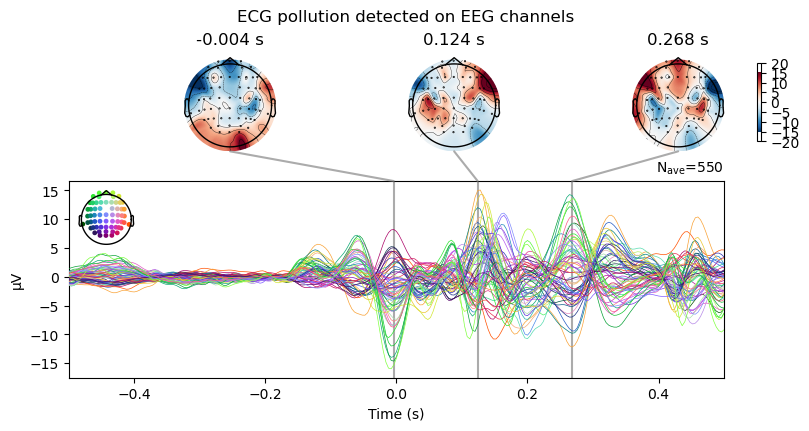

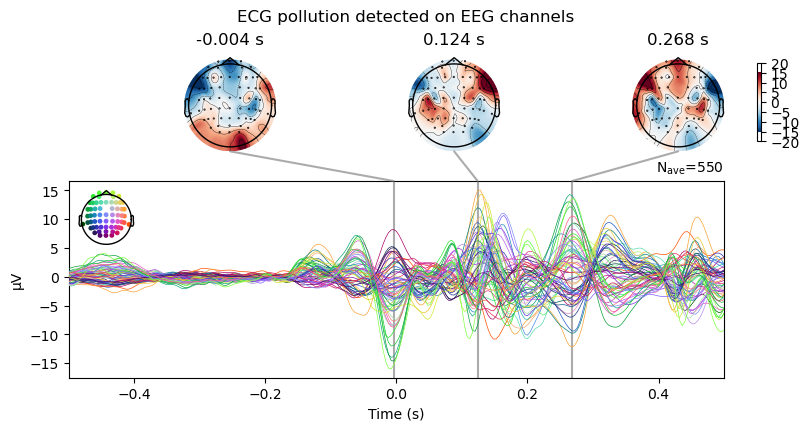

In [5]:
ecg_evoked = mne.preprocessing.create_ecg_epochs(raw,l_freq=2,h_freq=20).average()
ecg_evoked.plot_joint(title='ECG pollution detected on EEG channels')

In [6]:
ecg_projs, ecg_events = mne.preprocessing.compute_proj_ecg(raw, n_eeg=2, reject=None)

Including 3 SSP projectors from raw file
Running ECG SSP computation
Using channel ECG to identify heart beats.
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 5.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 4.75 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 35.25 Hz)
- Filter length: 2500 samples (10.000 s)

Number of ECG events detected : 569 (average pulse 54 / min.)
Computing projector
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband edge: 1.00
- Lower tra

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


0 bad epochs dropped
No channels 'grad' found. Skipping.
No channels 'mag' found. Skipping.
Adding projection: eeg--0.200-0.400-PCA-01
Adding projection: eeg--0.200-0.400-PCA-02
Done.


5 projection items deactivated


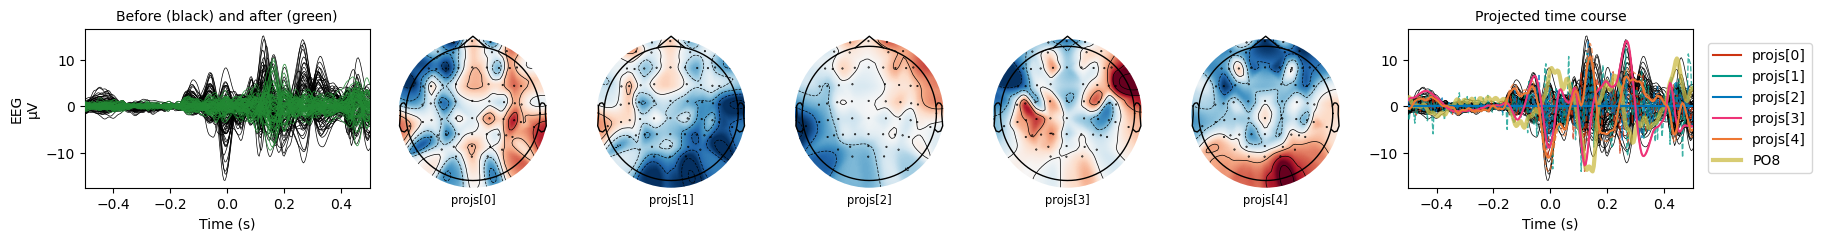

Text(0.5, 0.98, 'ECG projectors')

In [7]:
fig = mne.viz.plot_projs_joint(ecg_projs, ecg_evoked, picks_trace="PO8")
fig.suptitle("ECG projectors")

In [8]:
raw.add_proj(ecg_projs)

5 projection items deactivated


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,64 points
Good channels,"61 EEG, 1 ECG, 2 EOG"
Bad channels,None
EOG channels,"EOGL, EOGU"
ECG channels,ECG
Sampling frequency,250.00 Hz
Highpass,1.00 Hz
Lowpass,40.00 Hz


## SSP projection for EOGs

In [9]:
raw.apply_proj()

Created an SSP operator (subspace dimension = 5)
5 projection items activated
SSP projectors applied...


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,64 points
Good channels,"61 EEG, 1 ECG, 2 EOG"
Bad channels,None
EOG channels,"EOGL, EOGU"
ECG channels,ECG
Sampling frequency,250.00 Hz
Highpass,1.00 Hz
Lowpass,40.00 Hz


Using EOG channels: Fp1, Fp2
EOG channel index for this subject is: [0 1]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel Fp2 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 600 significant peaks
Number of EOG events detected: 600
Not setting metadata
600 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 5)
5 projection items activated
Using data from preloaded Raw for 600 event

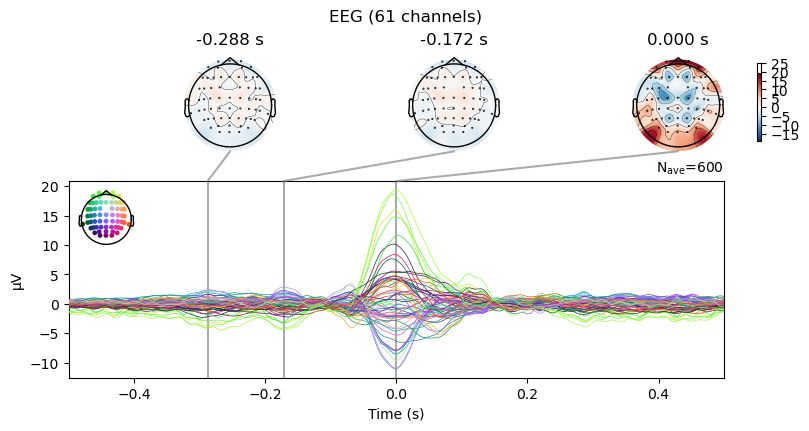

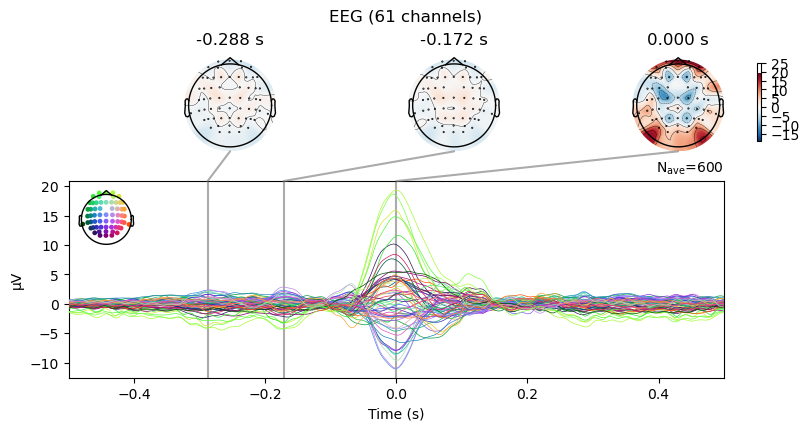

In [10]:
eog_evoked = mne.preprocessing.create_eog_epochs(raw,ch_name=['Fp1','Fp2',]).average()
eog_evoked.apply_baseline((None, None))
eog_evoked.plot_joint()

Running EOG SSP computation
Using EOG channels: EOGU, Fp1, Fp2
EOG channel index for this subject is: [ 0  1 63]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EOGU for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 s)



/var/folders/vd/l8fttcc54wx1zsr0tcq9zs6c0000gn/T/ipykernel_47751/786499527.py:1: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  eog_projs, eog_events = mne.preprocessing.compute_proj_eog(raw, ch_name = ["EOGU","Fp1", "Fp2"], n_eeg=2, reject=None,no_proj=True)


Now detecting blinks and generating corresponding events
Found 759 significant peaks
Number of EOG events detected: 759
Computing projector
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 35.25 Hz)
- Filter length: 2500 samples (10.000 s)

Not setting metadata
759 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 5)
5 projection items activated
Using data from preloaded Raw for 759 events and 101 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


0 bad epochs dropped
No channels 'grad' found. Skipping.
No channels 'mag' found. Skipping.
Adding projection: eeg--0.200-0.200-PCA-01
Adding projection: eeg--0.200-0.200-PCA-02
Done.
2 projection items deactivated


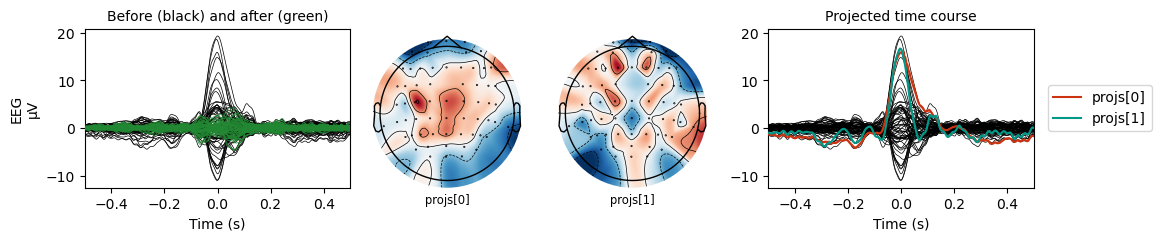

Text(0.5, 0.98, 'EOG projectors')

In [11]:
eog_projs, eog_events = mne.preprocessing.compute_proj_eog(raw, ch_name = ["EOGU","Fp1", "Fp2"], n_eeg=2, reject=None,no_proj=True)

fig = mne.viz.plot_projs_joint(eog_projs, eog_evoked)# picks_trace=["EOGL","EOGU"])
fig.suptitle("EOG projectors")

In [12]:
raw.add_proj(eog_projs, remove_existing=False)
raw.apply_proj()
raw.plot()

2 projection items deactivated
Created an SSP operator (subspace dimension = 7)
7 projection items activated
SSP projectors applied...
Using pyopengl with version 3.1.6


Channels marked as bad:
none


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)


/Users/samuel/anaconda3/envs/mne/lib/python3.11/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


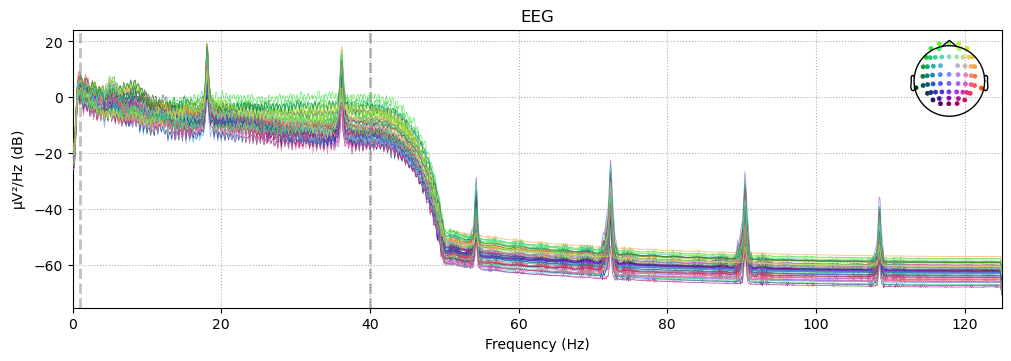

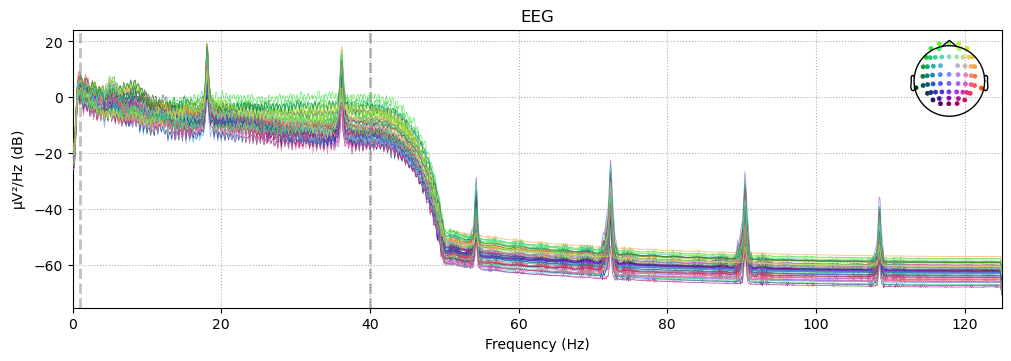

In [13]:
raw.plot_psd()

In [14]:
ica = mne.preprocessing.ICA(method='picard', random_state=2)
ica.fit(raw)
ica.plot_sources(raw, 
                 title='ICA sources',
                 show_scrollbars=True,
                 block=True)
ica.apply(raw)

Fitting ICA to data using 61 channels (please be patient, this may take a while)
    Applying projection operator with 7 vectors (pre-whitener computation)
    Applying projection operator with 7 vectors (pre-whitener application)
Selecting by non-zero PCA components: 54 components
    Applying projection operator with 7 vectors (pre-whitener application)
Fitting ICA took 15.7s.
    Applying projection operator with 7 vectors (pre-whitener application)
Creating RawArray with float64 data, n_channels=57, n_times=156705
    Range : 0 ... 156704 =      0.000 ...   626.816 secs
Ready.
Using pyopengl with version 3.1.6
    Applying projection operator with 7 vectors (pre-whitener application)
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
313 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
313 matching events found
No baseline correction appl

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,64 points
Good channels,"61 EEG, 1 ECG, 2 EOG"
Bad channels,None
EOG channels,"EOGL, EOGU"
ECG channels,ECG
Sampling frequency,250.00 Hz
Highpass,1.00 Hz
Lowpass,40.00 Hz


In [15]:
fname = './sub-01_ses-01_task-rest_run-01_desc-HomeMadePipeline_eeg.eeg'
mne.export.export_raw(fname, raw, fmt='brainvision', overwrite=True)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Setting 5539 of 173280 (3.20%) samples to NaN, retaining 167741 (96.80%) samples.
Effective window size : 8.192 (s)


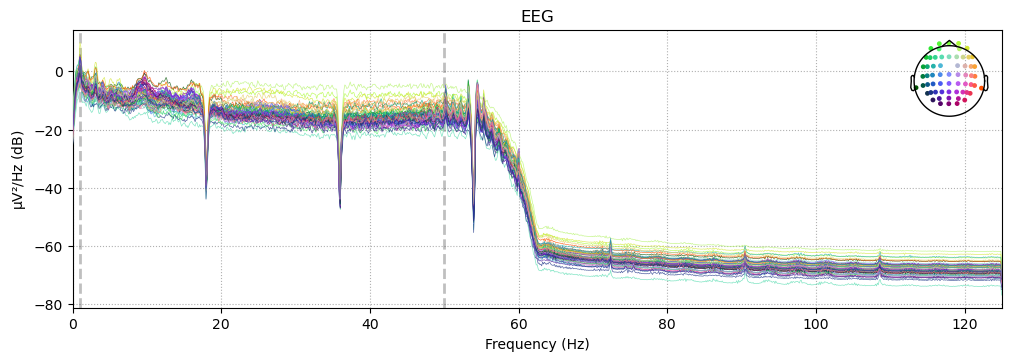

In [40]:
%matplotlib qt
raw.plot_psd()

In [50]:
raw.plot()

Using pyopengl with version 3.1.6


In [51]:
raw2 = mne.io.read_raw_edf("/Users/samuel/codes/eeg_fmri/derivatives/ballistocardiography_removal_2/sub-04_ses-01_task-rest_run-01_eeg.edf", preload=True)

Extracting EDF parameters from /Users/samuel/codes/eeg_fmri/derivatives/ballistocardiography_removal_2/sub-04_ses-01_task-rest_run-01_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 173499  =      0.000 ...   693.996 secs...
Using pyopengl with version 3.1.6


Channels marked as bad:
none
Channels marked as bad:
none


In [54]:
raw.plot(duration = 10, 
         start = 273,
         n_channels=20)
raw2.plot(duration = 10,
          start = 273,
          n_channels=20)

Using pyopengl with version 3.1.6
Using pyopengl with version 3.1.6


Channels marked as bad:
none
Channels marked as bad:
none


In [74]:
import matplotlib.pyplot as plt
for r, title in zip([raw_raw, raw2, raw], ['before cleaning', 'Brain Product Software', 'Homemade Pipeline']):
    with mne.viz.use_browser_backend("matplotlib"):
            fig = r.plot(events = None,
                         duration = 10, 
                         start = 273,
                         n_channels=20,
                         show_options=False,
                         overview_mode='hidden'
                         )
    fig.subplots_adjust(top=0.9)  # make room for title
    fig.suptitle(title, size="xx-large", weight="bold")
    plt.savefig(f"raw_{title}.png", dpi=300)

Using matplotlib as 2D backend.
Using qt as 2D backend.
Using matplotlib as 2D backend.
Using qt as 2D backend.
Using matplotlib as 2D backend.
Using qt as 2D backend.


Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Setting 5539 of 173280 (3.20%) samples to NaN, retaining 167741 (96.80%) samples.
Effective window size : 8.192 (s)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Setting 5539 of 173280 (3.20%) samples to NaN, retaining 167741 (96.80%) samples.
Effective window size : 8.192 (s)


/var/folders/vd/l8fttcc54wx1zsr0tcq9zs6c0000gn/T/ipykernel_16244/2455471641.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw2.plot_psd()


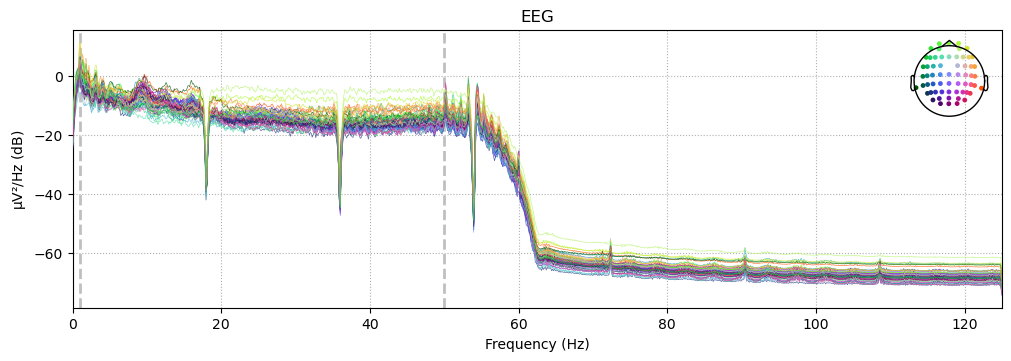

qt.qpa.window: Window position QRect(872,1081 100x30) outside any known screen, using primary screen


In [77]:
raw_raw.plot_psd()
raw2.plot_psd()
raw.plot_psd()